### Import necessary libaries 

In [1]:
import sys
import os
import gc
import numpy as np
import pandas as pd 
import tensorflow
import tensorflow.compat.v2 as tf
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/creditCardFraud/AnomalyDetection/scripts/")

In [3]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

In [4]:
# make sure GPU is running 
tf.test.gpu_device_name()
set_gpu_limit(7.5)

## Import training and dev data and convert to numpy array for NN 

In [5]:
train = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/TrainingData_normal.csv")
dev = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/DevData_normal.csv")

### garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### converting into tf data set to allow simple efficient data pipelines. 
* In autoencoder, you are predicting the original input x 
* shuffle and train data in batches with max 200 epochs 

In [7]:
batch_size = 256
epochs = 200
sizes = [20,10,7]
input_size = train.shape[1]

In [8]:
train_set, dev_set = make_tensor_dataset([train,dev],batch_size)

### set up checkpoint and other settings 

In [9]:
checkpoint = tfk.callbacks.ModelCheckpoint(f"{home}/Documents/projects/creditCardFraud/savedModels/encoderModel_2.h5",verbose=1,save_best_only=True)
earlystop = tfk.callbacks.EarlyStopping(monitor="val_loss", mode="min", min_delta=0.001, patience=20, verbose=1, restore_best_weights=True)

## encoder model for autoencoder:
* encoder: 3 layers:
  * 3 dense layers 

### Add encoders together 


In [10]:
autoencoder = make_autoencoder(sizes,input_size)

In [11]:
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
sequential (Sequential)      (None, 7)                 907       
_________________________________________________________________
decoder (Sequential)         (None, 30)                930       
Total params: 1,837
Trainable params: 1,837
Non-trainable params: 0
_________________________________________________________________


### compile the model and train model

In [12]:
autoencoder.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-3), loss="mse")

In [13]:
history = autoencoder.fit(train_set,epochs=epochs,shuffle=True,
                          verbose=1,validation_data=dev_set,
                          callbacks=[checkpoint,earlystop])

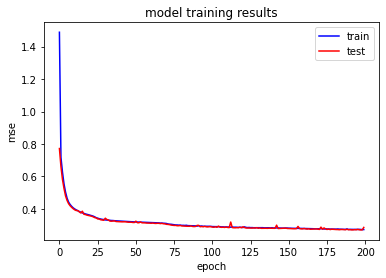

In [14]:
plot_loss(history)

In [14]:
autoencoder.load_weights(f"{home}/Documents/projects/creditCardFraud/savedModels/encoderModel_1.h5")

### garbage collect again

In [15]:
gc.collect()
%reset -f out

Flushing output cache (0 entries)


### Load in test dataset to see the results 

In [16]:
test = pd.read_csv(f"{home}/Documents/projects/creditCardFraud/processedData/hold_outset_moreFraud.csv")

In [17]:
test_tf_data, label = test.drop("Class",axis=1).values, test["Class"]

### pred prob score , no need to do negative prob score here just mse

In [18]:
pred_x = autoencoder.predict(test_tf_data)
pred_mse = np.mean(np.square(test_tf_data-pred_x),axis=1)

In [19]:
results = model_results(label,pred_mse)
print("anomaly:")
print(results[results.label==1]["anomaly_prob"].describe())
print()
print("normal:")
print(results[results.label==0]["anomaly_prob"].describe())

anomaly:
count    492.000000
mean      17.789460
std       20.508353
min        0.047780
25%        3.690617
50%        8.231428
75%       23.488609
max       83.645033
Name: anomaly_prob, dtype: float64

normal:
count    56858.000000
mean         0.285602
std          0.689788
min          0.010171
25%          0.122193
50%          0.193985
75%          0.312907
max         42.440587
Name: anomaly_prob, dtype: float64


### based upon stats we have an indea on where to set the threshold and trial and error

* ~ 50% quantile of anomalous data

In [20]:
output = model_results(label,pred_mse,threshold=7.1,ifprint=True)

[[56807    51]
 [  215   277]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56858
           1       0.84      0.56      0.68       492

    accuracy                           1.00     57350
   macro avg       0.92      0.78      0.84     57350
weighted avg       0.99      1.00      0.99     57350

